In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf

import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2", input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=100

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset/unchanged",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 895 files belonging to 8 classes.


['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

22

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds)

22

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds)

22

In [ ]:
len(test_ds)

4

In [ ]:
feature_extractor_model = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)



In [ ]:
pretrained_model_without_top_layer = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


# Display the summary of the model to see layer names
pretrained_model_without_top_layer.summary()

94668760/94668760 [==============================] - 2s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

In [ ]:
num_of_classes = 8

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    layers.GlobalMaxPooling2D(),  # Global max pooling layer
    layers.Dropout(0.5),
    layers.Dense(num_of_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23581192 (89.96 MB)
Trainable params: 23535752 (89.78 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tfk.optimizers.Adamax(learning_rate= lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_ds,validation_data=val_ds, batch_size=32,epochs=25)

Epoch 1/25
22/22 [==============================] - 711s 25s/step - loss: 7.5941 - accuracy: 0.3926 - val_loss: 74.0596 - val_accuracy: 0.1094
Epoch 2/25
22/22 [==============================] - 490s 22s/step - loss: 2.5950 - accuracy: 0.4879 - val_loss: 20.7289 - val_accuracy: 0.1094
Epoch 3/25
22/22 [==============================] - 492s 22s/step - loss: 1.5694 - accuracy: 0.5491 - val_loss: 42.9869 - val_accuracy: 0.1094
Epoch 4/25
22/22 [==============================] - 471s 21s/step - loss: 1.1143 - accuracy: 0.6145 - val_loss: 19.8170 - val_accuracy: 0.2500
Epoch 5/25
22/22 [==============================] - 471s 21s/step - loss: 1.0006 - accuracy: 0.6515 - val_loss: 4.4167 - val_accuracy: 0.5156
Epoch 6/25
22/22 [==============================] - 493s 22s/step - loss: 0.9951 - accuracy: 0.6216 - val_loss: 1.5772 - val_accuracy: 0.5938
Epoch 7/25
22/22 [==============================] - 497s 23s/step - loss: 0.8411 - accuracy: 0.6615 - val_loss: 1.2838 - val_accuracy: 0.5625
Ep

In [ ]:
len(test_ds)

3

In [ ]:
model.evaluate(train_ds)

22/22 [==============================] - 132s 6s/step - loss: 0.4609 - accuracy: 0.8265


[0.46090078353881836, 0.8264580368995667]

In [ ]:
model.evaluate(test_ds)

4/4 [==============================] - 54s 5s/step - loss: 0.3741 - accuracy: 0.8516


[0.3741338551044464, 0.8515625]

In [ ]:
model.evaluate(val_ds)

2/2 [==============================] - 10s 6s/step - loss: 0.2775 - accuracy: 0.8594


[0.2775169610977173, 0.859375]

In [ ]:
accuracy = history.history['accuracy']


loss = history.history['loss']


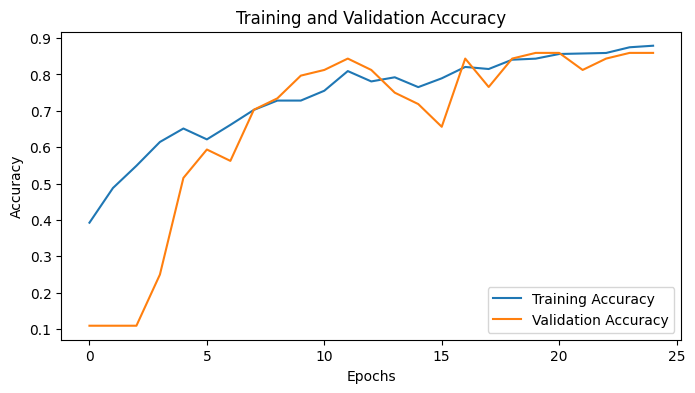

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


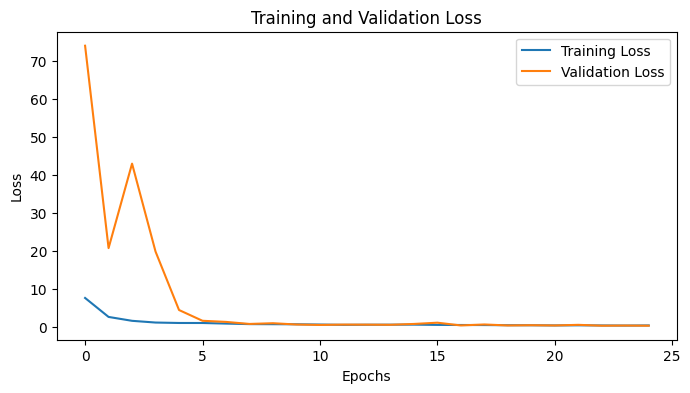

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


first image to predict
actual label: white spot
1/1 [==============================] - 8s 8s/step
predicted label: algal leaf


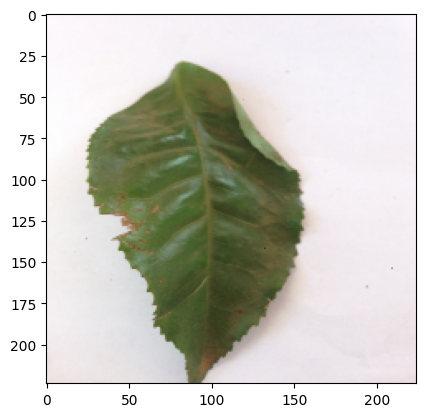

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 183ms/step


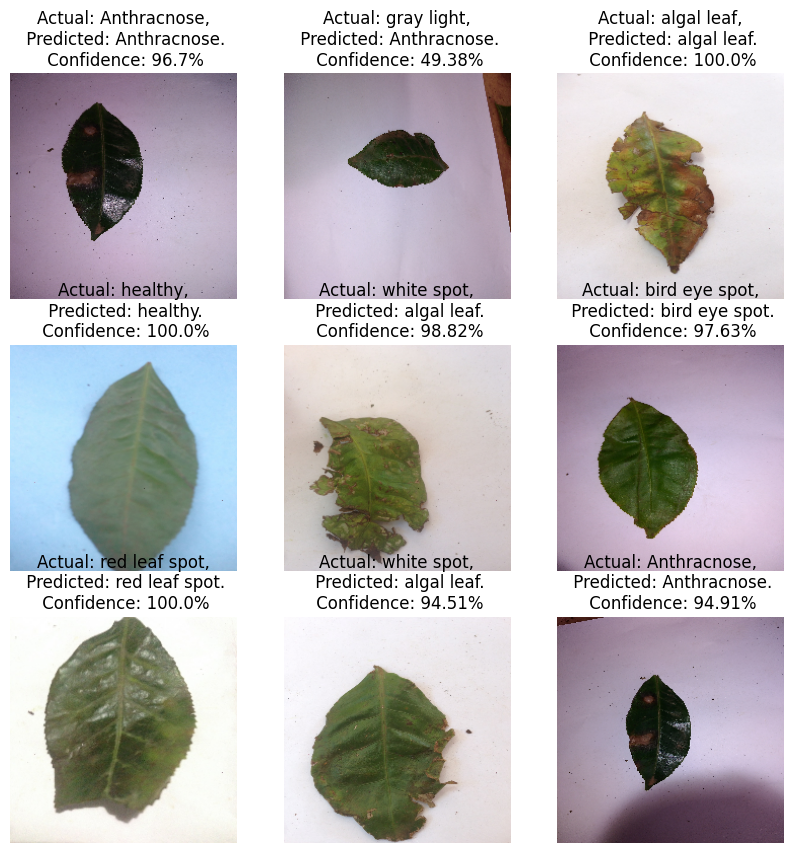

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
from keras.models import load_model

model_name = 'model_transfer_resnet_withchanged_maxPOOLING.hdf5'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
